# Rekonstruktion von Morse-Codes mithilfe von LSTM-Netwerken

Ziel dieses Projektes ist es, die Leerzeichen beziehungsweise die Pausen zwischen den Darstellungen einzelner Buchstaben im Morsecode mithilfe eines rekurrenten LSTM-Netzwerkes zu rekonstruieren. Obwohl durch das Weglassen der Leerzeichen im Prinzip Information verloren geht, ergeben meistens nur bestimmte Positionen der Leerzeichen sinnvolle Wörter.

In [1]:
import tensorflow as tf
import numpy as np

## Morse-Kodierung

Zuerst schreiben wir eine Funktion `to_morse`, die ein Wort in Morse-Code übersetzt

In [2]:
morse_code = {
    'A': '.-',     'B': '-...',   'C': '-.-.',   'D': '-..',    'E': '.',      'F': '..-.',
    'G': '--.',    'H': '....',   'I': '..',     'J': '.---',   'K': '-.-',    'L': '.-..',
    'M': '--',     'N': '-.',     'O': '---',    'P': '.--.',   'Q': '--.-',   'R': '.-.',
    'S': '...',    'T': '-',      'U': '..-',    'V': '...-',   'W': '.--',    'X': '-..-',
    'Y': '-.--',   'Z': '--..' }

In [3]:
def to_morse_word(word):
    word = word.upper()
    if not all([x in morse_code for x in word]):
        raise Exception("Wort enthält Zeichen außerhalb des englischen Alphabets")
    return ' '.join([morse_code[x] for x in word])
def to_morse(phrase):
    return 'X'.join([to_morse_word(word) for word in phrase.split(" ")])

Test der Funktion:

In [4]:
to_morse("SOS")

'... --- ...'

## Eingabe und Ausgabe des neuronalen Netzwerkes

Wir müssen uns zuerst fragen, wie die Ein- und Ausgabe des Netzwerkes kodiert sein soll. Wie alle neuronalen Netze besteht die Eingabe eines LSTM-Modells nicht aus Zeichen, sondern aus Gleitkommazahlen.

Die Eingabe soll ein Morse-Code sein. Da die Leerzeichen weggelassen wurden, besteht dieser nur aus zwei Zeichen. Ein häufiges Verfahren für die Kodierung kategorischer Daten ist das *one-hot encoding*. Die folgende Funktion implementiert diese Codierung der Eingabe, wobei die Leerzeichen im Morsecode automatisch weggelassen werden.

**Look-ahead** Es ist schwierig für das neuronale Netz, zu entscheiden, wo die Morse-Codes unterbrochen werden sollen, ohne wenigstens ein paar Zeichen vorwärts schauen zu können. Daher verschiebe ich einfach Ein- und Ausgabe mithilfe eines einstellbaren look-aheads gegeneinander. Anders gesagt, das neuronale Netz muss erst einige Zeichen später signalisieren, dass ein Leerzeichen eingefügt werden soll.

In [5]:
lookahead = 10

Die Eingabe wird als `float`-Array kodiert, damit man sie direkt ins neuronale Netzwerk einspeisen kann.

In [6]:
def encode_input(morse):
    encodings = { '.': [1, 0, 0], '-': [0, 1, 0], 'X': [0, 0, 1] }
    return np.array([encodings[x] for x in (morse #+ lookahead*"X" 
                                           )if x != ' ']).astype(float)

In [7]:
encode_input(to_morse("SOS V"))

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

Die Ausgabe des Netzwerkes möchte ich so machen, dass das Netz für jedes Eingabezeichen entscheiden soll, ob nach diesem Zeichen ein Leerzeichen wahrscheinlich ist. Die gewünschte Ausgabe ist also `1`, wenn auf ein Zeichen im ursprünglichen Morsecode ein Leerzeichen folgt, und sonst `0`. Für das letzte Zeichen macht es Sinn, `1` vorzuschreiben, da das Wortende ja auch ein Buchstabenende ist. Die folgende Funktion implementiert die gewünschte Ausgabe:

In [8]:
def compute_target(morse):
    return np.array(#lookahead*[0] + 
        [int((b == " ") | (b == "X")) for a,b in zip(morse[:-1], morse[1:]) if a != " "] + [1]).astype(float)

In [9]:
compute_target(to_morse("SOS"))

array([0., 0., 1., 0., 0., 1., 0., 0., 1.])

Bei "SOS" haben alle Buchstaben drei Zeichen, deshalb besteht die gewünscht Ausgabe aus drei gleichen Teilen.

## Trainings-Daten generieren

In [10]:
with open("dataset0.txt", "r") as f:
    words = f.read()

In [11]:
assert all([x.upper() in morse_code or x == "\n" for x in words])

In [12]:
words = words.split("\n")[:-1]

In [13]:
def get_random_phrase(length):
    phrase = ""
    while len(phrase) < length:
        if phrase != "":
            phrase += " "
        phrase += words[np.random.randint(len(words))]
    return phrase
def make_training_data(length):
    phrase = get_random_phrase(length)
    morse = to_morse(phrase)
    inputs = encode_input(morse)
    targets = compute_target(morse)
    inputs = inputs[:length]
    targets = targets[:length]
    return inputs, targets

In [14]:
get_random_phrase(50)

'room fry fast baseball degrees soul score rugby reading'

In [15]:
def make_batches(n_batches, length):
    inputs, targets = [np.zeros((n_batches, length, k)) for k in [3,1]]
    for i in range(n_batches):
        inputs[i], targets[i,:,0] = make_training_data(length)
    return inputs, targets

In [16]:
morse_all = [to_morse(w) for w in words]

In [17]:
np.amax([len(x) for x in morse_all])

50

In [18]:
words_all = np.zeros((len(words), 50 + lookahead, 3))
outs_all = np.zeros((len(words), 50 + lookahead, 1))

In [19]:
morse_all[1]

'.- --. . -. -.-. -.--'

In [20]:
for i in range(len(words)):
    c = morse_all[i]
    print(len(c), encode_input(c).shape)
    enc = encode_input(c)
    outs_all[i,lookahead:lookahead+enc.shape[0],0] = compute_target(c)
    words_all[i, :enc.shape[0]] = enc
    words_all[i, enc.shape[0]:] = [0,0,1]

27 (20, 3)
21 (16, 3)
25 (19, 3)
17 (13, 3)
23 (17, 3)
14 (10, 3)
8 (6, 3)
9 (7, 3)
13 (11, 3)
14 (11, 3)
15 (12, 3)
22 (16, 3)
10 (8, 3)
24 (18, 3)
25 (18, 3)
17 (13, 3)
24 (18, 3)
19 (15, 3)
20 (16, 3)
18 (13, 3)
19 (14, 3)
30 (22, 3)
14 (10, 3)
21 (16, 3)
20 (16, 3)
22 (17, 3)
24 (18, 3)
26 (19, 3)
28 (20, 3)
45 (33, 3)
28 (20, 3)
29 (22, 3)
35 (27, 3)
19 (14, 3)
28 (20, 3)
25 (19, 3)
38 (26, 3)
33 (24, 3)
21 (16, 3)
20 (15, 3)
14 (11, 3)
30 (22, 3)
11 (9, 3)
24 (18, 3)
24 (19, 3)
9 (7, 3)
25 (18, 3)
29 (21, 3)
32 (24, 3)
18 (13, 3)
19 (14, 3)
8 (6, 3)
7 (5, 3)
13 (10, 3)
16 (13, 3)
22 (18, 3)
34 (24, 3)
19 (14, 3)
33 (26, 3)
20 (14, 3)
16 (12, 3)
27 (21, 3)
30 (22, 3)
38 (28, 3)
30 (22, 3)
26 (19, 3)
40 (29, 3)
36 (25, 3)
11 (8, 3)
33 (24, 3)
17 (13, 3)
16 (12, 3)
24 (17, 3)
9 (7, 3)
19 (14, 3)
19 (14, 3)
29 (22, 3)
18 (13, 3)
14 (11, 3)
18 (12, 3)
7 (5, 3)
15 (10, 3)
22 (16, 3)
23 (15, 3)
32 (22, 3)
18 (13, 3)
21 (14, 3)
26 (20, 3)
20 (14, 3)
20 (15, 3)
30 (21, 3)
8 (6, 3)
23 (17,

In [21]:
words_all.shape, outs_all.shape

((1922, 60, 3), (1922, 60, 1))

## Trainings-Daten aus Text

In [22]:
with open("dataset0.txt", "r") as f:
    text = f.read()
text = "".join([x for x in text if x == "\n" or x == " " or (x.upper() in morse_code)])
text = text.replace("\n", " ")
text = " ".join(text.split())

In [23]:
" ".join("abc def ghi".split())

'abc def ghi'

In [24]:
text[:500]

'activity agency ability actor actress agree aim air job able prep airline add airport addition alarm address album awful admire accent admission admit accept allow access advance accident advantage accommodation adventure alphabet accompany advert advertise account advertisement accountant advice advise ache aeroplane adv achieve afford act ambition afternoon ambulance amount action age det page conj apply appointment animal approach athlete ankle approve athletics anniversary architect announce'

In [25]:
def make_batch(length):
    pos = np.random.randint(len(text) - length + 50)
    subtext = text[pos : pos + length + 50]
    idx = subtext[:50].find(" ")
    if idx > 0:
        subtext = subtext[idx : length + idx]
    morse = to_morse(subtext)
    inputs = encode_input(morse)
    targets = compute_target(morse)
    inputs = inputs[:length]
    targets = targets[:length]
    return inputs, targets

def make_batches(n_batches, length):
    inputs, targets = [np.zeros((n_batches, length, k)) for k in [3,1]]
    for i in range(n_batches):
        inputs[i], targets[i,:,0] = make_batch(length)
    return inputs, targets

## Morse-Dekodieren zum Testen

In [26]:
morse_inverse = { code: letter for letter, code in morse_code.items() }

In [27]:
def morse_decode_word(with_spaces):
    codes = with_spaces.split(" ")
    return "".join([morse_inverse[x] if x in morse_inverse else "?" for x in codes])
def morse_decode(s):
    return " ".join([morse_decode_word(x) for x in s.split("X")])

In [28]:
def remove_spaces(s):
    return "".join([x for x in s if x != " "])

In [29]:
def insert_spaces(s_no_spaces, output=None):
    inp_encode = encode_input(s_no_spaces + lookahead*"X")
    if output is None:
        output = model(inp_encode.reshape(1,-1,3)).numpy()[0,:,0][lookahead:]
    with_spaces = ""
    for i in range(len(s_no_spaces)):
        char = s_no_spaces[i]
        with_spaces += char
        if output[i] > 0 and i < len(s_no_spaces) - 1 and s_no_spaces[i+1] != "X" and s_no_spaces[i] != "X":
            with_spaces += " "
    return with_spaces

## Möglichkeiten generieren

In [30]:
def generate_possibilites(no_spaces):
    if no_spaces == "":
        return [""]
    poss = []
    for i in range(1, len(no_spaces)+1):
        if no_spaces[:i] in morse_inverse:
            lett = morse_inverse[no_spaces[:i]]
            poss_rest = generate_possibilites(no_spaces[i:])
            poss += [lett + x for x in poss_rest]
    return poss

In [31]:
len(words)

1922

## Definition und Training des Modells

In [32]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(300, return_sequences=True))
#model.add(tf.keras.layers.Dense(150, activation='relu'))
#model.add(tf.keras.layers.LSTM(250, return_sequences=True))
#model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.LSTM(400, return_sequences=True))
model.add(tf.keras.layers.Dense(1000, activation='relu'))
#model.add(tf.keras.layers.Dense(2000, activation='relu'))
#model.add(tf.keras.layers.LSTM(60, return_sequences=True))
model.add(tf.keras.layers.Dense(1))

In [33]:
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])


STEP 1 / 15
Epoch 1/20
61/61 [==============================] - 24s 17ms/step - loss: 0.2271 - accuracy: 0.9002
Epoch 2/20
61/61 [==============================] - 1s 15ms/step - loss: 0.1688 - accuracy: 0.9088
Epoch 3/20
61/61 [==============================] - 1s 15ms/step - loss: 0.1714 - accuracy: 0.9061
Epoch 4/20
61/61 [==============================] - 1s 14ms/step - loss: 0.1576 - accuracy: 0.9139
Epoch 5/20
61/61 [==============================] - 1s 14ms/step - loss: 0.1583 - accuracy: 0.9129
Epoch 6/20
61/61 [==============================] - 1s 14ms/step - loss: 0.1563 - accuracy: 0.9141
Epoch 7/20
61/61 [==============================] - 1s 15ms/step - loss: 0.1542 - accuracy: 0.9140
Epoch 8/20
61/61 [==============================] - 1s 14ms/step - loss: 0.1535 - accuracy: 0.9141
Epoch 9/20
61/61 [==============================] - 1s 15ms/step - loss: 0.1536 - accuracy: 0.9141
Epoch 10/20
61/61 [==============================] - 1s 14ms/step - loss: 0.1536 - accuracy: 0.9

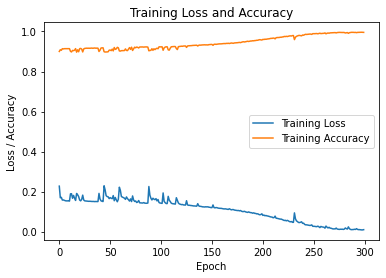

In [34]:
import matplotlib.pyplot as plt

n_iter = 15
train_loss_history = []
train_acc_history = []

for i in range(n_iter):
    print("STEP {} / {}".format(i+1, n_iter))
    history = model.fit(words_all, outs_all, epochs=20)
    train_loss_history += history.history['loss']
    train_acc_history += history.history['accuracy']
    
    for i in range(15, 25):
        word = words[i]
        rec = morse_decode(insert_spaces(remove_spaces(to_morse_word(word))))
        print(word, rec)

plt.plot(train_loss_history, label='Training Loss')
plt.plot(train_acc_history, label='Training Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()


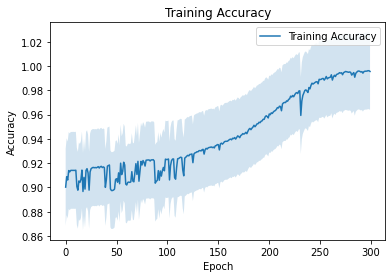

In [44]:
plt.plot(train_acc_history, label='Training Accuracy')
plt.fill_between(range(len(train_acc_history)), train_acc_history - np.std(train_acc_history), train_acc_history + np.std(train_acc_history), alpha=0.2)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


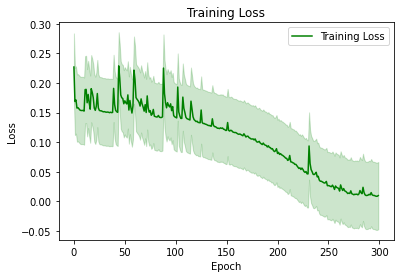

In [47]:
plt.plot(train_loss_history, color='green', label='Training Loss')
plt.fill_between(range(len(train_loss_history)), train_loss_history - np.std(train_loss_history), train_loss_history + np.std(train_loss_history), alpha=0.2, color='green')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [35]:
from tensorflow import keras
from google.colab import files
model.save('ModellSmall.h5')
files.download('ModellSmall.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
tf.nn.softmax([-10.0])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

In [37]:
morse_orig = to_morse_word("hamburg")
print(morse_orig)

.... .- -- -... ..- .-. --.


In [38]:
nospace = remove_spaces(morse_orig)
print(nospace)

.....----.....-.-.--.


In [39]:
reconstructed = insert_spaces(nospace)
print(reconstructed)

... ..- -- -. .. .. -. -. --.


In [40]:
morse_decode(reconstructed)

'SUMNIINNG'

In [45]:
from sklearn.metrics import f1_score
import numpy as np
from tensorflow import keras


outs_all_flat = outs_all.reshape((1922*60,))
words_all_flat = words_all.reshape((1922*60, 3))

# Load the test data
x_test = words_all_flat
y_test = outs_all_flat

# Load the saved model
model = keras.models.load_model('1.h5')

# Reshape the true labels and predicted labels
y_true = y_test.reshape(-1, 3)
x_test = x_test.reshape(-1, 60, 3)

y_pred = model.predict(x_test).reshape(-1, 3)

# Apply a threshold to obtain binary predictions
threshold = 0.5
binary_predicted_labels = (y_pred >= threshold).astype(int)

# Calculate the F1 score, accuracy, and precision
f1 = f1_score(y_true, binary_predicted_labels, average='weighted')

# Print the evaluation scores
print("F1 score:", f1)



61/61 [==============================] - 1s 9ms/step
F1 score: 0.9818608527520735
